# CSE151B Project

In [91]:
import numpy as np
import pandas as pd
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Task Description

<center>regression task to predict the duration of a taxi ride given information about the time it was called.</center>

## Preprocessing

In [92]:
df_tr = pd.read_csv("data/train.csv")
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [93]:
df_tr.shape

(1710670, 9)

## Training - before data processing
training data has 1710670 entries and a total of 9 features. 8 features are inputs with the 9th feature (polyline) representing the output.

In [94]:
df_te = pd.read_csv('data/test_public.csv')
df_te.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False


In [95]:
df_te.shape

(320, 8)

## Testing - before data processing
testing data has 320 entries and a total of 8 features. Output feature is omitted (meant to be predicted).

## Data Engineering
1. convert polyline feature into an actual numerical duration of the trip (formula: (len(polyline)-1) * 15)
2. parse out trip details from time stamp column
3. filter out entries with missing data (only 10 entries had missing data)
4. Encode call_type into integers
5. Encode call_day into integers

In [96]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [97]:
def parse_time(x):
  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed 
#(year, month, day, hour, weekday) tuples on the column axis, or axis 1
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_te[["YR", "MON", "DAY", "HR", "WK"]] = df_te[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

## Training - post processing
1710670 entries, 15 features now. 13 are input, 2 are output. Some redundancy is present. New feature were derived from timestamp column and consist of the year, month, day, hour, and week of the taxi call. a new output feature len was calculated representing the duration in seconds.

In [98]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,6,30,17,6
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,6,30,17,6
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,6,30,17,6
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,6,30,17,6
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,6,30,17,6


In [99]:
df_tr.shape

(1710670, 15)

## Testing - post processing
320 entries, 13 features. 5 new features were derived from timestamp column.

In [100]:
df_te.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK
0,T1,B,NaN,15.0,20000542,1408039037,A,False,2014,8,14,10,3
1,T2,B,NaN,57.0,20000108,1408038611,A,False,2014,8,14,10,3
2,T3,B,NaN,15.0,20000370,1408038568,A,False,2014,8,14,10,3
3,T4,B,NaN,53.0,20000492,1408039090,A,False,2014,8,14,10,3
4,T5,B,NaN,18.0,20000621,1408039177,A,False,2014,8,14,10,3


In [101]:
df_te.shape

(320, 13)

## Pulling Useful Features for Training
notes: timestamp breaks stuff bc big numbers, day_type is meaningless feature bc only class A calls exist in the dataset, origin_call and origin_stand do not seem to be useful features because they're essentially ID's. TRIP_ID and TAXI_ID are not useful for the same reason. MISSING_DATA is not useful (duh). So we work with call type, year, month, day, hour, week -- follows logical reasoning since these are the only ones that would affect taxi trip durations.

Pull out train, test sets

<b>YEAR AND TIMESTAMP BREAK SHIT BC BIG NUMBERS</b>

In [102]:
set(df_te['DAY_TYPE'])

{'A'}

In [103]:
# only 10 entries supposely had missing data
X = (
    df_tr[df_tr['MISSING_DATA']==False]
     [['CALL_TYPE','MON','DAY','HR','WK']]
    )

# encode category
X['CALL_TYPE'] = X['CALL_TYPE'].apply(lambda x: 0 if x=='A' else 1 if x=='B' else 2)

y = df_tr[df_tr['MISSING_DATA']==False]['LEN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Basic EDA

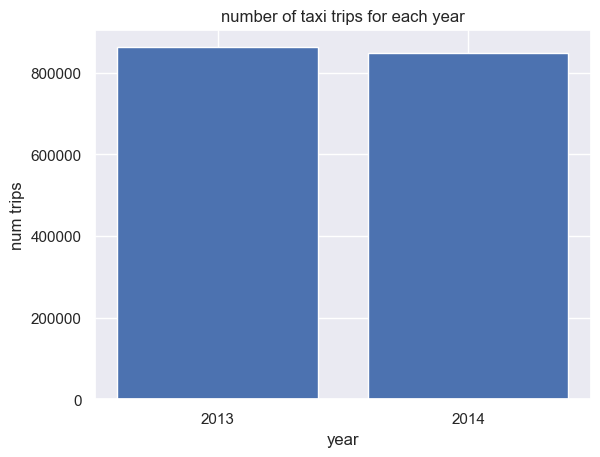

In [104]:
year_data = list(df_tr['YR'].value_counts().items())
plt.bar([str(x[0]) for x in year_data], [x[1] for x in year_data])
plt.title('number of taxi trips for each year')
plt.xlabel('year')
plt.ylabel('num trips')
plt.show()

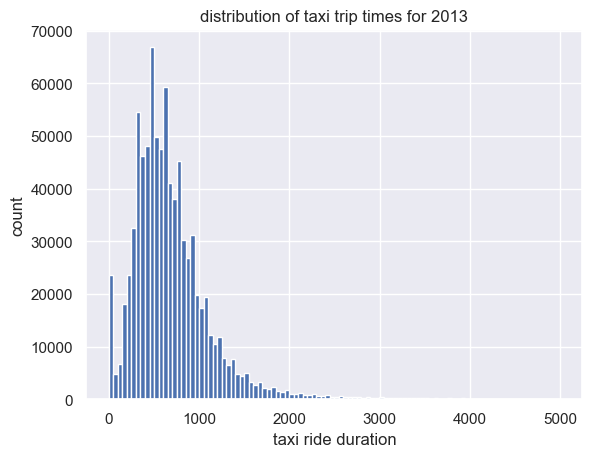

In [105]:
# get rid of disgusting outliers, who rides a taxi for 14 hours
plt.hist(df_tr[df_tr['YR'] == 2013]['LEN'][df_tr['LEN'] < 5000],100)
plt.title('distribution of taxi trip times for 2013')
plt.xlabel('taxi ride duration')
plt.ylabel('count')
plt.show()

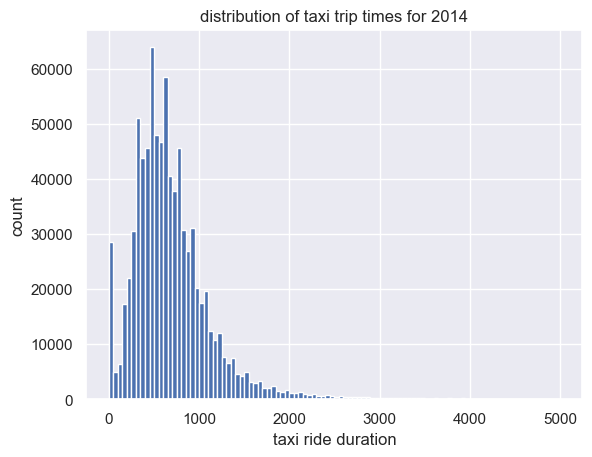

In [106]:
# get rid of disgusting outliers, who rides a taxi for 14 hours
plt.hist(df_tr[df_tr['YR'] == 2014]['LEN'][df_tr['LEN'] < 5000],100)
plt.title('distribution of taxi trip times for 2014')
plt.xlabel('taxi ride duration')
plt.ylabel('count')
plt.show()

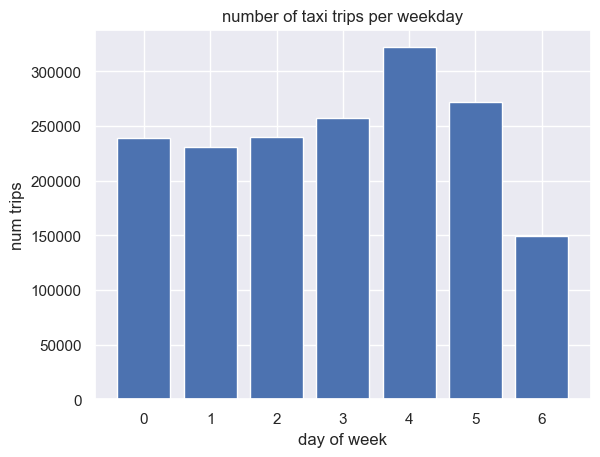

In [107]:
# trip density by days of week // 0 is monday // friday is most popoular - friday night drinking?
dow_data = list(df_tr['WK'].value_counts().items())
dow_data.sort(key = lambda x:x[0])
plt.bar([str(x[0]) for x in dow_data], [x[1] for x in dow_data])
plt.title('number of taxi trips per weekday')
plt.xlabel('day of week')
plt.ylabel('num trips')
plt.show()

## Baseline

In [23]:
regr = RandomForestRegressor(max_depth=100, random_state=42, criterion = 'squared_error', n_jobs=-1)
regr.fit(X_train, y_train);

In [24]:
preds = regr.predict(X_test)
MSE(preds, y_test, squared=False)

686.2613574516279

## Deep Learning Model

In [45]:
# convert to tensors
X_train = torch.from_numpy(X_train.values).to(torch.float32)
y_train = torch.tensor(np.array(y_train)).to(torch.float32).reshape(-1,1)
X_test = torch.from_numpy(X_test.values).to(torch.float32)
y_test = torch.tensor(np.array(y_test)).to(torch.float32).reshape(-1,1)

In [46]:
data_train = TensorDataset(X_train, y_train)
data_test = TensorDataset(X_test, y_test)

In [47]:
batch_size = 64
num_workers = 2
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [48]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [52]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(5,256),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(256,64),
        )

        self.layer3 = nn.Sequential(
            nn.Linear(64,16),
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(16,1)
        )
        
    def forward(self, x):
        x = self.layer1(x)      
        x = self.layer2(x)      
        x = self.layer3(x)      
        x = self.layer4(x)    
        return x

In [53]:
# # simplified model because my hair is leaving my head
# class model(nn.Module):
#     def __init__(self):
#         super(model, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Linear(2,8),
#         )
        
#         self.layer2 = nn.Sequential(
#             nn.Linear(8,4),
#         )
        
#         self.layer3 = nn.Sequential(
#             nn.Linear(4,1),
#         )
        
#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         return x

## Training

In [56]:
from tqdm import tqdm

training_losses = []
testing_losses = []
# train step
criterion = RMSELoss()
net = model()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

for epoch in tqdm(range(50)):
    for x,y in train_loader:
        y_pred = net(x)
        loss  = criterion(y_pred, y)
        training_losses.append((epoch, loss))
        testing_losses.append((epoch, MSE(net(X_test).detach().numpy(), y_test)))
        loss.backward()

        optimizer.step()

        optimizer.zero_grad()
        
        
    print('epoch {}, loss {}'.format(epoch, loss.item()))

print('Finished Training')

  2%|▉                                           | 1/50 [00:20<16:21, 20.03s/it]

epoch 0, loss 425.11163330078125


  4%|█▊                                          | 2/50 [00:40<16:01, 20.04s/it]

epoch 1, loss 486.4861145019531


  6%|██▋                                         | 3/50 [00:59<15:36, 19.92s/it]

epoch 2, loss 469.7162780761719


  8%|███▌                                        | 4/50 [01:20<15:37, 20.38s/it]

epoch 3, loss 224.19606018066406


 10%|████▍                                       | 5/50 [01:54<18:47, 25.06s/it]

epoch 4, loss 388.0029296875


 12%|█████▎                                      | 6/50 [02:16<17:34, 23.97s/it]

epoch 5, loss 6534.64013671875


 14%|██████▏                                     | 7/50 [02:36<16:22, 22.86s/it]

epoch 6, loss 416.3177185058594


 16%|███████                                     | 8/50 [02:59<16:03, 22.93s/it]

epoch 7, loss 321.804443359375


 18%|███████▉                                    | 9/50 [03:21<15:23, 22.51s/it]

epoch 8, loss 501.5346374511719


 20%|████████▌                                  | 10/50 [03:42<14:39, 21.99s/it]

epoch 9, loss 472.68182373046875


 22%|█████████▍                                 | 11/50 [04:02<13:52, 21.35s/it]

epoch 10, loss 788.0112915039062


 24%|██████████▎                                | 12/50 [04:22<13:22, 21.11s/it]

epoch 11, loss 608.9964599609375


 26%|███████████▏                               | 13/50 [04:43<12:55, 20.97s/it]

epoch 12, loss 580.6529541015625


 28%|████████████                               | 14/50 [05:04<12:39, 21.10s/it]

epoch 13, loss 399.83770751953125


 30%|████████████▉                              | 15/50 [05:25<12:19, 21.12s/it]

epoch 14, loss 305.1127014160156


 32%|█████████████▊                             | 16/50 [05:45<11:45, 20.76s/it]

epoch 15, loss 482.75543212890625


 34%|██████████████▌                            | 17/50 [06:05<11:19, 20.58s/it]

epoch 16, loss 841.7276611328125


 36%|███████████████▍                           | 18/50 [06:25<10:51, 20.37s/it]

epoch 17, loss 364.1501770019531


 38%|████████████████▎                          | 19/50 [06:45<10:27, 20.24s/it]

epoch 18, loss 442.41717529296875


 40%|█████████████████▏                         | 20/50 [07:05<10:04, 20.15s/it]

epoch 19, loss 440.03363037109375


 42%|██████████████████                         | 21/50 [07:25<09:44, 20.16s/it]

epoch 20, loss 699.9367065429688


 44%|██████████████████▉                        | 22/50 [07:46<09:25, 20.19s/it]

epoch 21, loss 306.5539855957031


 46%|███████████████████▊                       | 23/50 [08:06<09:04, 20.17s/it]

epoch 22, loss 828.3010864257812


 48%|████████████████████▋                      | 24/50 [08:26<08:43, 20.13s/it]

epoch 23, loss 289.9992370605469


 50%|█████████████████████▌                     | 25/50 [08:46<08:23, 20.13s/it]

epoch 24, loss 420.13323974609375


 52%|██████████████████████▎                    | 26/50 [09:06<08:03, 20.16s/it]

epoch 25, loss 396.0608825683594


 54%|███████████████████████▏                   | 27/50 [09:26<07:41, 20.08s/it]

epoch 26, loss 336.5995178222656


 56%|████████████████████████                   | 28/50 [09:46<07:20, 20.04s/it]

epoch 27, loss 795.72216796875


 58%|████████████████████████▉                  | 29/50 [10:06<07:00, 20.03s/it]

epoch 28, loss 502.9667053222656


 60%|█████████████████████████▊                 | 30/50 [10:26<06:42, 20.12s/it]

epoch 29, loss 388.9847412109375


 62%|██████████████████████████▋                | 31/50 [10:46<06:20, 20.04s/it]

epoch 30, loss 914.782958984375


 64%|███████████████████████████▌               | 32/50 [11:06<05:59, 19.99s/it]

epoch 31, loss 573.2691650390625


 66%|████████████████████████████▍              | 33/50 [11:26<05:39, 19.97s/it]

epoch 32, loss 347.6796875


 68%|█████████████████████████████▏             | 34/50 [11:46<05:21, 20.07s/it]

epoch 33, loss 830.15869140625


 70%|██████████████████████████████             | 35/50 [12:10<05:16, 21.09s/it]

epoch 34, loss 489.69244384765625


 72%|██████████████████████████████▉            | 36/50 [12:30<04:53, 20.93s/it]

epoch 35, loss 969.2665405273438


 74%|███████████████████████████████▊           | 37/50 [12:51<04:31, 20.85s/it]

epoch 36, loss 507.814208984375


 76%|████████████████████████████████▋          | 38/50 [13:12<04:09, 20.81s/it]

epoch 37, loss 828.8241577148438


 78%|█████████████████████████████████▌         | 39/50 [13:32<03:47, 20.70s/it]

epoch 38, loss 859.1681518554688


 80%|██████████████████████████████████▍        | 40/50 [13:52<03:25, 20.53s/it]

epoch 39, loss 1124.142333984375


 82%|███████████████████████████████████▎       | 41/50 [14:12<03:03, 20.41s/it]

epoch 40, loss 401.73248291015625


 84%|████████████████████████████████████       | 42/50 [14:33<02:42, 20.34s/it]

epoch 41, loss 506.2231750488281


 86%|████████████████████████████████████▉      | 43/50 [14:53<02:21, 20.28s/it]

epoch 42, loss 449.1893615722656


 88%|█████████████████████████████████████▊     | 44/50 [15:17<02:08, 21.38s/it]

epoch 43, loss 898.3692016601562


 90%|██████████████████████████████████████▋    | 45/50 [15:37<01:45, 21.07s/it]

epoch 44, loss 525.8903198242188


 92%|███████████████████████████████████████▌   | 46/50 [15:57<01:23, 20.77s/it]

epoch 45, loss 440.3982238769531


 94%|████████████████████████████████████████▍  | 47/50 [16:18<01:02, 20.68s/it]

epoch 46, loss 406.7191162109375


 96%|█████████████████████████████████████████▎ | 48/50 [16:38<00:41, 20.66s/it]

epoch 47, loss 315.23681640625


 98%|██████████████████████████████████████████▏| 49/50 [16:59<00:20, 20.68s/it]

epoch 48, loss 458.5614929199219


100%|███████████████████████████████████████████| 50/50 [17:19<00:00, 20.79s/it]

epoch 49, loss 553.0585327148438
Finished Training


In [57]:
torch.save(net, 'model.pth')

## Testing

In [62]:
preds = net(X_test).detach().numpy()
MSE(preds, y_test, squared=False)

691.4648

## Prediction Submission

In [69]:
X_out = (
    df_te[df_te['MISSING_DATA']==False]
     [['CALL_TYPE','MON','DAY','HR','WK']]
    )
# encode category
X_out['CALL_TYPE'] = X_out['CALL_TYPE'].apply(lambda x: 0 if x=='A' else 1 if x=='B' else 2)
X_out = torch.from_numpy(X_out.values).to(torch.float32)

In [90]:
preds_out = net(X_out).detach().numpy()
df_out = pd.DataFrame(data = {'TRIP_ID': np.array(df_te['TRIP_ID']), 'TRAVEL_TIME': preds_out.flatten()})
df_out.to_csv('my_preds.csv', index=False)

,TRIP_ID,TRAVEL_TIME
0,T1,656.907104
1,T2,656.907104
2,T3,656.907104
3,T4,656.907104
4,T5,656.907104
